## Imports

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from PyBNG import PyBNG
import shapely
from os import makedirs, path, listdir, remove
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import requests
import zipfile as zpf
from tqdm import tqdm
from PIL import Image

/home/users/mwlw3/miniconda3/envs/AQmort/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## netCDF files: Processing & exploration

In [67]:
folder = "/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/006/"

In [68]:
files = [path.join(folder, file) for file in listdir(folder) if path.splitext(file)[-1]==".nc"]

In [193]:
ds = xr.open_dataset(files[0])


 53%|█████▎    | 189/359 [00:23<00:08, 19.80it/s]

In [194]:
ds

<xarray.Dataset>
Dimensions:                               (nPoints_XY: 16, nPoints_XYZ: 16, nMetLines: 7, nGroups: 1, nDatasets: 5, OutputOptionsUsed: 3, NumberOfTypesOfOutputPoint: 5)
Dimensions without coordinates: nPoints_XY, nPoints_XYZ, nMetLines, nGroups, nDatasets, OutputOptionsUsed, NumberOfTypesOfOutputPoint
Data variables: (12/23)
    PointX_XY                             (nPoints_XY) float32 ...
    PointY_XY                             (nPoints_XY) float32 ...
    PointName_XY                          (nPoints_XY) |S44 ...
    PointX_XYZ                            (nPoints_XYZ) float32 ...
    PointY_XYZ                            (nPoints_XYZ) float32 ...
    PointZ_XYZ                            (nPoints_XYZ) float32 ...
    ...                                    ...
    Dataset4                              (nMetLines, nGroups, nPoints_XYZ) float32 ...
    Dataset5                              (nMetLines, nGroups, nPoints_XYZ) float32 ...
    Output_Options_Description            (OutputOptionsUsed) |S14 ...
    Output_Options_Used                   (OutputOptionsUsed) int32 ...
    Output_Points_Type                    (NumberOfTypesOfOutputPoint) |S16 ...
    Number_Of_Output_Points_Of_Each_Type  (NumberOfTypesOfOutputPoint) int32 ...
Attributes: (12/14)
    File_Version:               2.0
    File_Type:                  Comprehensive output file
    Site_Name:                  Greater London
    Project_Name:               Preliminary 2019 with P-G classes, grid output
    Coordinate_System:          OSGB 1936 British National Grid (epsg:27700)
    EPSG:                       27700
    ...                         ...
    Model_Name:                 ADMS-Urban
    Model_Version:              5.0.0.1
    Model_Build_Number:         5129
    Model_Release_Date:         January 2020
    Date_Created:               21/1/2022
    Time_Created:               16:24:27

There is a Dataset for each pollutant species, e.g. the NO2 data is contained in `Dataset2`.

Each pollutant dataset has 7 Pasquill-Gifford weather condition classes, represented by met lines, and a space dimension, represented by XYZ point number. Each pollutant dataset also has a Groups dimension, which indicates a subset of emission sources (here there is only one Group, for "All sources").

To identify the Pasquill-Gifford class, a separate `Met_Line` dataset is numbered from 1 to 7.

To identify the spatial coordinates (OSGB (British National Grid)), the `PointX_XYZ`, `PointY_XYZ`, and `PointZ_XYZ` datasets contain the X, Y, and Z coordinates respectively.

The DataArray can be indexed like a `numpy` array e.g. to obtain only the concentrations through time at one spatial point e.g. `NO2_da[:,0,0].values`.

The DataArray can also be averaged over a dimension like a `numpy` array e.g. spatially averaged timeseries: `NO2_da.mean(axis=2).squeeze().values`. The `.squeeze()` function squeezes out the Groups dimension, since it has size 1.

Let's extract the datetime information from the Met_Line dataset:

In [8]:
def metline_to_datetime(i):
    numbers = str(i).replace("b", "").replace("'", "")
    return np.datetime64(f"{numbers[0]}")+ np.timedelta64(int(numbers[1])-1, "D") + np.timedelta64(int(numbers[2]), "h")

def extract_dataset_time_axis(ds):
    datetime_index = []
    for i in ds.Met_Line.values:
        datetime_index.append(metline_to_datetime(i))
    return datetime_index

In [ ]:
# datetime_index = extract_dataset_time_axis(ds)

Now we can plot a spatial average timeseries for NO2:

In [9]:
def plot_timeseries(dataframe, columns, title, units, figure_size=(8,4)):
    plt.figure(figsize=figure_size, dpi=300)
    for column in columns:
        dataframe[column].plot()
    plt.legend()
    plt.ylabel(units)
    plt.suptitle(title)
    plt.show()

Missing values are assigned as `-999` during ADMS-Urban modelling, so we replace these with NaNs.
NOTE: I think there aren't actually any -999 values in the data, just some really high concentrations.

In [ ]:
# plot_timeseries(dataframe=pd.DataFrame(ds.Dataset2.mean(axis=2).squeeze().values, index=datetime_index, columns=["spatial_mean_NO2"]).replace(-999, np.nan), 
#                 columns=["spatial_mean_NO2"], 
#                 title="Hourly ADMS-Urban predictions for London subset 00034", 
#                 units="NO$_2$ (µg m$^{-3}$)")

### Pasquill-Gifford classes

In [4]:
PG_index = ["A", "B", "C", "D", "E", "F", "G"]

### Space

The `PyBNG` library enables interconversion between the Ordnance Survey British National Grid (OS BNG) coordinates and latitude/longitude coordinates, which will be more useful for plotting and further analysis.

In [5]:
def PointXYZ_to_latlon(PointXs, PointYs):
    df = pd.DataFrame()
    for X, Y in zip(PointXs.astype(int), PointYs.astype(int)):
        latlon = PyBNG(easting=X, northing=Y).get_latlon()
        df = df.append([latlon])
    df.columns = ["latitude", "longitude"]
    df.reset_index(drop=True, inplace=True)
    return df

<AxesSubplot:>

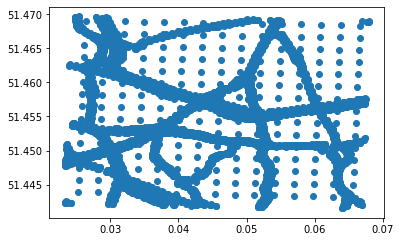

In [12]:
latlon_df = PointXYZ_to_latlon(ds.PointX_XYZ.values, 
                                  ds.PointY_XYZ.values)
gdf = gpd.GeoDataFrame(latlon_df, geometry=gpd.points_from_xy(latlon_df.longitude, latlon_df.latitude))

gdf.plot()

To plot this on a map of London, we can download the London borough GIS boundaries from the London Datastore:

In [13]:
url = "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip"
tmp_folder = path.join(path.abspath(""), "tmp")
filename = path.basename(url)
filepath = path.join(tmp_folder, filename)

In [14]:
new_download = False

if new_download:
    file = open(filepath, 'wb')
    file.write(requests.get(url).content)
    file.close()
    zpf.ZipFile(filepath, 'r').extractall(tmp_folder)

Load the London Boroughs shapefile and convert to the latitude/longitude coordinate system by referencing the EPSG code `4326`:

In [15]:
shapefilepath = path.join(tmp_folder, "statistical-gis-boundaries-london", "ESRI",
                         "London_Borough_Excluding_MHW.shp")
london_boroughs_gdf = gpd.read_file(shapefilepath).to_crs(epsg=4326)

CRSError: Invalid projection: epsg:4326: (Internal Proj Error: proj_create: no database context specified)

In [6]:
def plot_on_map(data_geodataframe, map_geodataframe, column=None, title="Greater London", fontsize="25", figsize=(20,10), data_color=None, data_cmap=None, colorbar=False, set_colorbar_max=False, set_colorbar_log=False, data_markersize=0.1, map_color="whitesmoke", map_edge_color="black", axis="off"):
    data_geodataframe.plot(column=column, ax=map_geodataframe.plot(figsize=figsize, color=map_color, edgecolor=map_edge_color),
                          color=data_color, cmap=data_cmap, markersize=data_markersize)
    if colorbar:
        if set_colorbar_max:
            colorbar_max = set_colorbar_max
        else:
            colorbar_max = data_geodataframe[column].max()
        if set_colorbar_log:
            norm = colors.LogNorm(data_geodataframe[column].quantile(0.01), colorbar_max)
        else:
            norm = plt.Normalize(data_geodataframe[column].min(), colorbar_max)
        plt.colorbar(plt.cm.ScalarMappable(cmap=data_cmap, 
        norm=norm)).set_label(column)
    plt.suptitle(title, fontsize=fontsize)
    plt.axis(axis)
    plt.show()

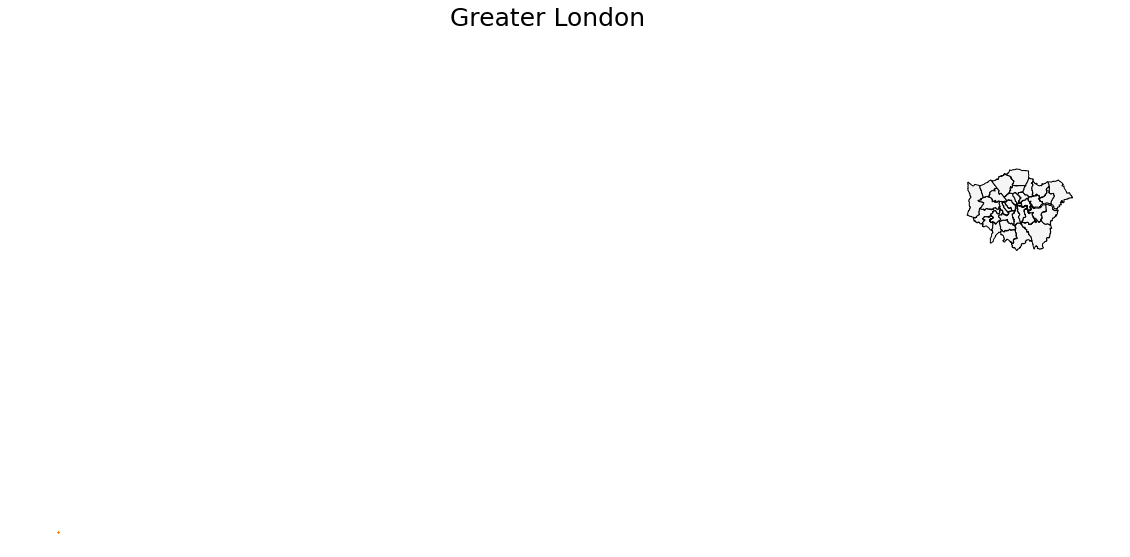

In [55]:
plot_on_map(gdf, london_boroughs_gdf, data_color="tab:orange")

Select a Pasquill-Gifford class to estimate NO2 concentration at each output point and join the GeoDataFrame with the spatial points:

In [6]:
choose_PG_class = "A"

In [7]:
space_gdf = gpd.GeoDataFrame(ds.Dataset2[PG_index.index(choose_PG_class),0,:].squeeze().values, 
                  index=gdf.index, 
                  columns=[f"Class_{choose_PG_class}_NO2"]).join(gdf)

NameError: name 'ds' is not defined

In [7]:
def plot_in_grid_box(geodataframe, column, title, figsize=(10,5), fontsize=15, markersize=0.1, cmap="plasma_r", colorbar=True, colorbar_label=None, colorbar_scale=False, edgecolor=None):
    geodataframe.plot(column=column, figsize=figsize, markersize=markersize, cmap=cmap, edgecolor=edgecolor)
    colorbar_max = geodataframe[column].max()
    if colorbar_scale == "log":
        norm = colors.LogNorm(geodataframe[column].quantile(0.01), colorbar_max)
    else:
        norm = plt.Normalize(geodataframe[column].min(), colorbar_max)
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), label=colorbar_label)
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.suptitle(title, fontsize=fontsize)
    plt.show()

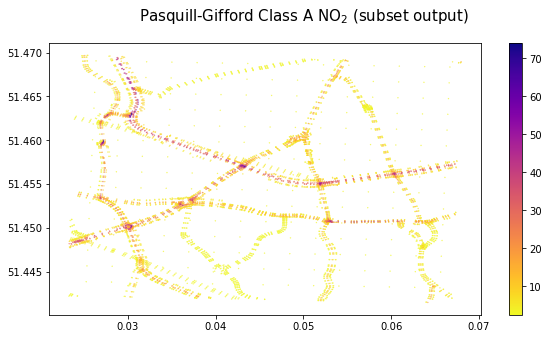

In [61]:
plot_in_grid_box(space_gdf, f"Class_{choose_PG_class}_NO2", title=f"Pasquill-Gifford Class {choose_PG_class} NO$_2$ (subset output)")

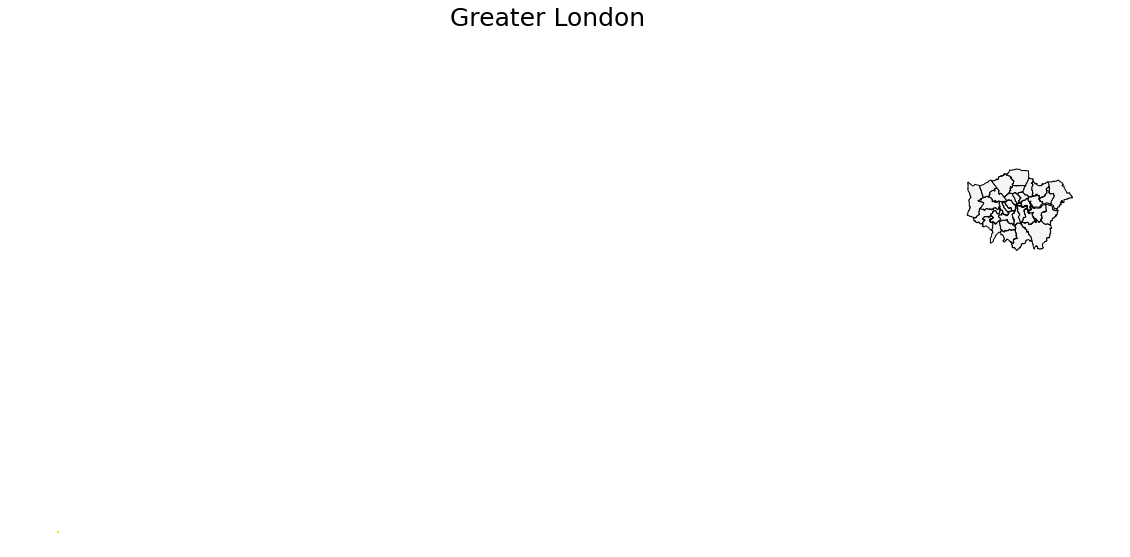

In [60]:
plot_on_map(space_gdf, london_boroughs_gdf, column=f"Class_{choose_PG_class}_NO2", data_cmap="plasma_r")

### New Dataset

We can make a new Dataset containing all of the pollutant concentrations, as well as meteorological variables:

In [21]:
def process_dataset(ds):
    data_variables = {
        ds.Dataset1.Pollutant_Name: (["PG_class", "space"], ds.Dataset1.values.reshape((ds.dims["nMetLines"],-1)), ds.Dataset1.attrs),
        ds.Dataset2.Pollutant_Name: (["PG_class", "space"], ds.Dataset2.values.reshape((ds.dims["nMetLines"],-1)), ds.Dataset2.attrs),
        ds.Dataset3.Pollutant_Name: (["PG_class", "space"], ds.Dataset3.values.reshape((ds.dims["nMetLines"],-1)), ds.Dataset3.attrs),
        ds.Dataset4.Pollutant_Name: (["PG_class", "space"], ds.Dataset4.values.reshape((ds.dims["nMetLines"],-1)), ds.Dataset4.attrs),
        ds.Dataset5.Pollutant_Name: (["PG_class", "space"], ds.Dataset5.values.reshape((ds.dims["nMetLines"],-1)), ds.Dataset5.attrs),
        "wind_speed_at_10m": (["PG_class"], ds.Met_UAt10m.values, ds.Met_UAt10m.attrs),
        "wind_direction": (["PG_class"], ds.Met_PHI.values, ds.Met_PHI.attrs)
                     }

    coords = {"Pasquill-Gifford": (["PG_class"], np.array(PG_index)),
         "latitude": (["space"], PointXYZ_to_latlon(ds.PointX_XYZ.values, ds.PointY_XYZ.values).latitude.values),
         "longitude": (["space"], PointXYZ_to_latlon(ds.PointX_XYZ.values, ds.PointY_XYZ.values).longitude.values)}

    attrs = ds.attrs

    return xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

Let's try loading multiple netCDF files:

In [69]:
files[:5]

['/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/006/006.00001.nc',
 '/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/006/006.00002.nc',
 '/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/006/006.00003.nc',
 '/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/006/006.00004.nc',
 '/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/006/006.00005.nc']

We concatentate the xarray datasets along the `space` dimension:

In [29]:
progress_bar = tqdm(range(0, len(files)))

new_ds = xr.concat([process_dataset(xr.open_dataset(files[i])) for i in progress_bar], "space")

100%|██████████| 359/359 [00:06<00:00, 54.54it/s]


In [73]:
new_ds

<xarray.Dataset>
Dimensions:            (PG_class: 7, space: 225)
Coordinates:
    Pasquill-Gifford   (PG_class) <U1 'A' 'B' 'C' 'D' 'E' 'F' 'G'
    latitude           (space) float64 51.44 51.44 51.44 ... 51.47 51.47 51.47
    longitude          (space) float64 0.1116 0.1145 0.1174 ... 0.1502 0.1531
Dimensions without coordinates: PG_class, space
Data variables:
    NOx                (PG_class, space) float32 16.78 16.84 ... 250.8 266.6
    NO2                (PG_class, space) float32 2.746 2.755 ... 40.2 40.68
    PM10               (PG_class, space) float32 1.61 1.613 ... 23.31 23.18
    PM2.5              (PG_class, space) float32 0.8993 0.9 ... 12.99 12.98
    CO2                (PG_class, space) float32 1.058e+04 ... 1.535e+05
    wind_speed_at_10m  (space, PG_class) float32 0.9995 2.0 4.999 ... 2.0 1.0
    wind_direction     (space, PG_class) float32 270.0 270.0 ... 270.0 270.0
Attributes: (12/14)
    File_Version:               2.0
    File_Type:                  Comprehensive output file
    Site_Name:                  Greater London region 1
    Project_Name:               Preliminary 2019 with P-G classes, grid output
    Coordinate_System:          OSGB 1936 British National Grid (epsg:27700)
    EPSG:                       27700
    ...                         ...
    Model_Name:                 ADMS-Urban
    Model_Version:              5.0.0.1
    Model_Build_Number:         5129
    Model_Release_Date:         January 2020
    Date_Created:               10/12/2021
    Time_Created:               14:47:21

In [30]:
# Save this for reloading later
new_ds.to_netcdf(path.join(folder, "raw_processed_coordinates.nc"))

In [70]:
# Reload dataset
new_ds = xr.open_dataset(path.join(folder, "raw_processed_coordinates.nc"))

Now we can make a Geopandas Dataframe for plotting:

In [97]:
choose_PG_class = "G"
data_column = f"Class_{choose_PG_class}_NO2"

In [98]:
new_gdf = gpd.GeoDataFrame(new_ds.NO2[PG_index.index(choose_PG_class),:].values, 
                 columns=[data_column], 
                 geometry=gpd.points_from_xy(new_ds.longitude.values, new_ds.latitude.values))

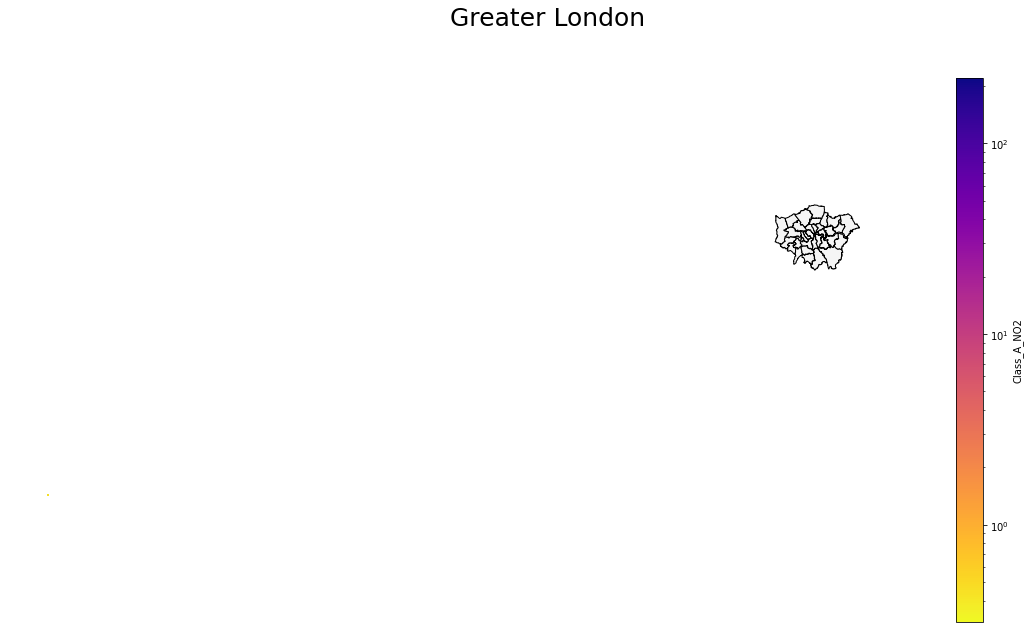

In [86]:
plot_on_map(new_gdf, london_boroughs_gdf, column=data_column, 
            data_cmap="plasma_r", colorbar=True, set_colorbar_log=True)

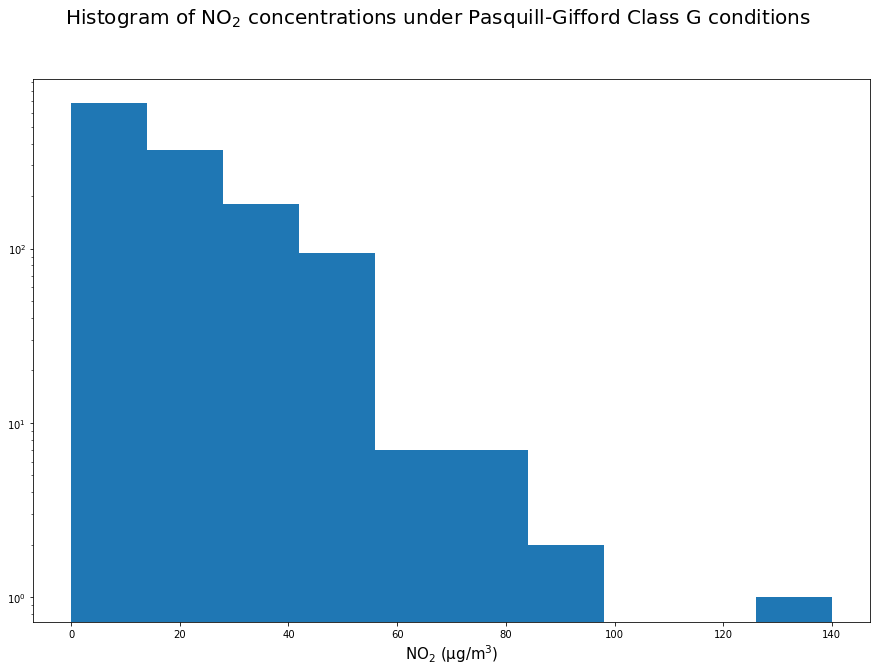

In [99]:
plt.figure(figsize=(15,10))
plt.hist(new_gdf[data_column].values)
plt.suptitle(f"Histogram of NO$_2$ concentrations under Pasquill-Gifford Class {choose_PG_class} conditions", fontsize=20)
plt.yscale("log")
plt.xlabel("NO$_2$ (μg/m$^3$)", fontsize=15)
plt.show()

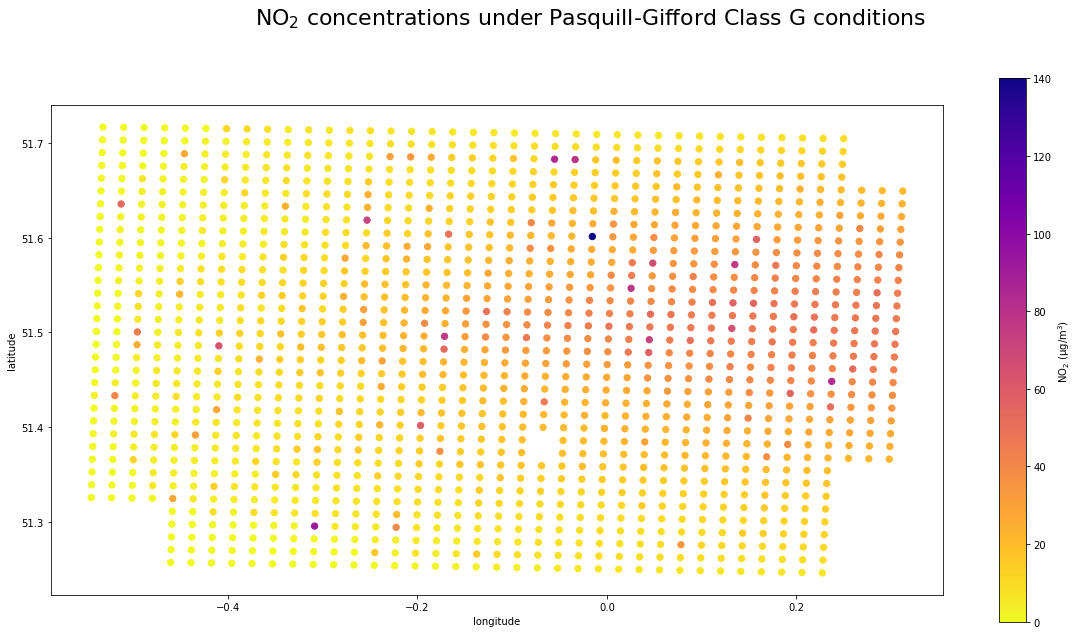

In [100]:
plot_in_grid_box(new_gdf, 
                 data_column, 
                 figsize=(20,10),
                 markersize=40, # 0.1 or more (depending on grid resolution)
                 title=f"NO$_2$ concentrations under Pasquill-Gifford Class {choose_PG_class} conditions", 
                 fontsize=22, 
                 colorbar_scale=None, # "log" or None
                 colorbar_label="NO$_2$ (μg/m$^3$)")

#### Re-gridding

So I'm currently using a dataset which is indexed by time and space i.e. my spatial dimension is a long list of coordinates indexed by longitude-latitude, rather than with longitude and latitude indexed separately so that the space is 2D.

Let's try gridding the data.

Adapted from [this tutorial](https://james-brennan.github.io/posts/fast_gridding_geopandas/).

In [18]:
xmin, ymin, xmax, ymax = new_gdf.total_bounds
n_cells = 150
cell_size = (xmax-xmin)/n_cells
grid_cells = [shapely.geometry.box(x0, y0, x0 - cell_size, y0 + cell_size) 
              for x0 in np.arange(xmin, xmax + cell_size, cell_size) 
              for y0 in np.arange(ymin, ymax + cell_size, cell_size)]

cell = gpd.GeoDataFrame(grid_cells, columns=["geometry"])

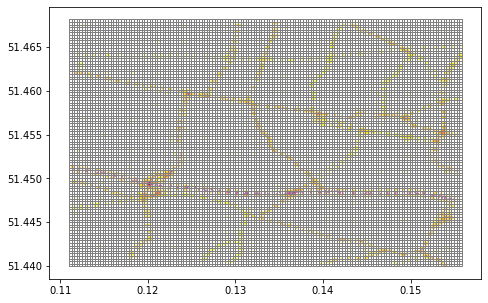

In [19]:
cell.plot(ax=new_gdf.plot(markersize=0.1, column=data_column, cmap="plasma_r", figsize=(10,5)), 
          facecolor="none", edgecolor="grey")
plt.show()

Merge the grid with the data points themselves:

In [20]:
merged_gdf = gpd.sjoin(new_gdf, cell, how="left", predicate="within")

Use the `.dissolve()` function to upsample the data to the grid:

In [21]:
dissolve = merged_gdf.dissolve(by="index_right", aggfunc="mean")
cell.loc[dissolve.index, data_column] = dissolve[data_column].values

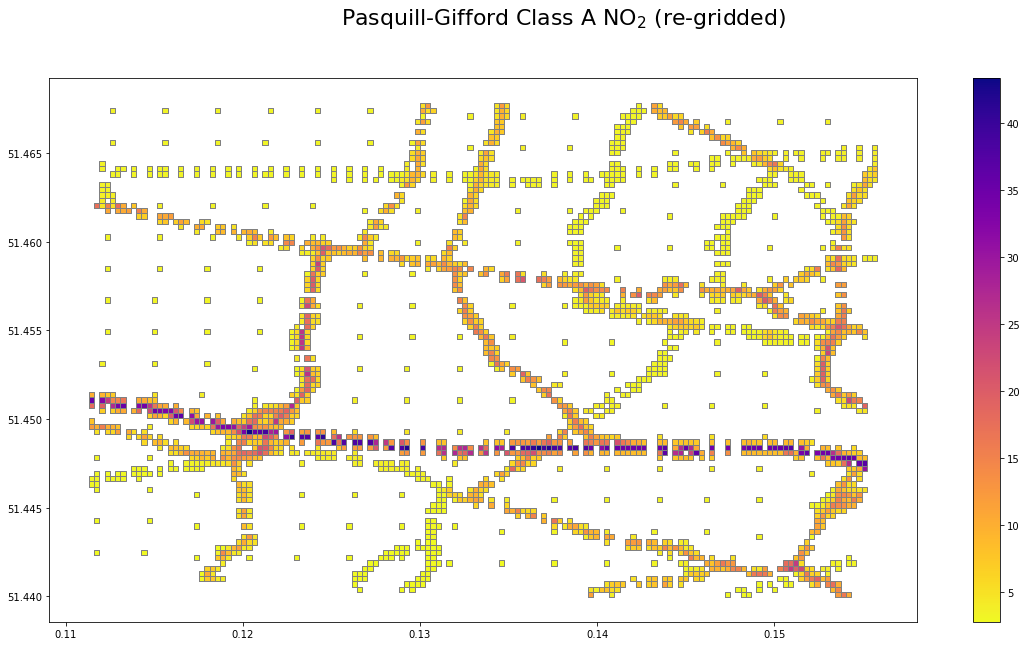

In [22]:
plot_in_grid_box(cell, 
                 data_column, 
                 figsize=(20,10), 
                 fontsize=22, 
                 title=f"Pasquill-Gifford Class {choose_PG_class} NO$_2$ (re-gridded)", 
                 edgecolor="grey")

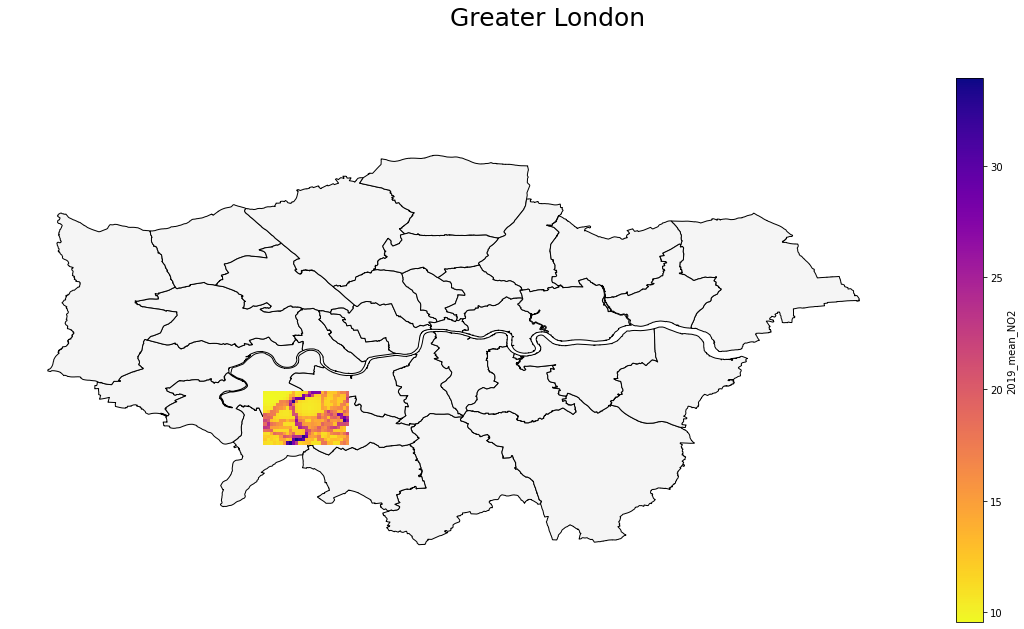

In [77]:
plot_on_map(cell, london_boroughs_gdf, column=data_column, data_cmap="plasma_r", colorbar=True)

This Pasquill-Gifford class data can be reshaped (what dimensions?) and made into an `xarray` dataset:

In [186]:
# What are the reshaping dimensions?
x_coords = cell.centroid.x.round(12).drop_duplicates()
y_coords = cell.centroid.y.round(12).drop_duplicates()
print(len(x_coords), len(y_coords), len(x_coords)*len(y_coords))
print(len(cell))

151 84 12684
12684


In [187]:
data_variables = {"NO2": (["longitude", "latitude"], cell[data_column].values.reshape(len(x_coords), len(y_coords)), new_ds.NO2.attrs)
                    }

coords = {"longitude": (["longitude"], x_coords),
            "latitude": (["latitude"], y_coords)}
     
attrs = new_ds.attrs

NO2_ds = xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

In [188]:
NO2_ds

<xarray.Dataset>
Dimensions:    (longitude: 151, latitude: 84)
Coordinates:
  * longitude  (longitude) float64 -0.5549 -0.5491 -0.5433 ... 0.304 0.3097
  * latitude   (latitude) float64 51.25 51.25 51.26 51.27 ... 51.72 51.72 51.73
Data variables:
    NO2        (longitude, latitude) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/14)
    File_Version:               2.0
    File_Type:                  Comprehensive output file
    Site_Name:                  Greater London
    Project_Name:               Preliminary 2019 with P-G classes
    Coordinate_System:          OSGB 1936 British National Grid (epsg:27700)
    EPSG:                       27700
    ...                         ...
    Model_Name:                 ADMS-Urban
    Model_Version:              5.0.0.1
    Model_Build_Number:         5129
    Model_Release_Date:         January 2020
    Date_Created:               9/12/2021
    Time_Created:               16:6:26

#### Pasquill-Gifford classes re-gridding

For the coordinate-processed `xarray` dataset, we need to re-grid each Pasquill-Gifford class and then reshape it...

I could loop through each P-G class and use `geopandas` to convert to a lat/lon grid, then stack the classes into a `numpy` array to then make into an `xarray` dataset:

In [191]:
xmin, ymin, xmax, ymax = gpd.points_from_xy(new_ds.longitude.values, 
                                            new_ds.latitude.values).total_bounds
n_cells = 150
cell_size = (xmax-xmin)/n_cells
grid_cells = [shapely.geometry.box(x0, y0, x0 - cell_size, y0 + cell_size) 
              for x0 in np.arange(xmin, xmax + cell_size, cell_size) 
              for y0 in np.arange(ymin, ymax + cell_size, cell_size)]

ref_cell = gpd.GeoDataFrame(grid_cells, columns=["geometry"])

In [192]:
x_coords = ref_cell.centroid.x.round(12).drop_duplicates()
y_coords = ref_cell.centroid.y.round(12).drop_duplicates()

#### For NO2 only

In [192]:
cell_list = []
progress_bar = tqdm(range(0, new_ds.PG_class.shape[0]))

for i in progress_bar:
    progress_bar.set_description(f"Gridding Pasquill-Gifford class")
    cell = ref_cell.copy()
    class_gdf = gpd.GeoDataFrame(new_ds.NO2[i, :].values, 
                     columns=["class_NO2"], 
                     geometry=gpd.points_from_xy(new_ds.longitude.values, new_ds.latitude.values))
    merge = gpd.sjoin(class_gdf, ref_cell, how="left", predicate="within")
    dissolve = merge.dissolve(by="index_right", aggfunc="mean")
    cell.loc[dissolve.index, "class_NO2"] = dissolve["class_NO2"].values
    cell_list.append(cell["class_NO2"].values.reshape(len(x_coords),len(y_coords)))

Gridding Pasquill-Gifford class: 100%|██████████| 7/7 [12:27<00:00, 106.72s/it]


In [194]:
classes_gridded = np.stack(cell_list, axis=-1)

classes_gridded.shape

(151, 84, 7)

In [195]:
data_variables = {"NO2": (["longitude", "latitude", "PG_class"], classes_gridded, new_ds.NO2.attrs)
                    }

coords = {"longitude": (["longitude"], x_coords),
            "latitude": (["latitude"], y_coords),
         "PG_class": (["PG_class"], new_ds.PG_class.data)}
     
attrs = new_ds.attrs

NO2_classes_ds = xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

Save to a netCDF file for easier loading of NO2 data in future.

In [197]:
NO2_classes_ds.to_netcdf(path.join(folder, "NO2_PG_classes_grid.nc"))

What about the wind data?

In [200]:
new_ds.wind_speed_at_10m.shape

(1344773, 7)

In [201]:
wind_speed = pd.DataFrame(new_ds.wind_speed_at_10m.mean(axis=0), 
                          columns=["wind_speed_at_10m"], 
                          index=new_ds.PG_class.data).replace(-999.000061, np.nan)
wind_speed.min()

wind_speed_at_10m    0.999466
dtype: float32

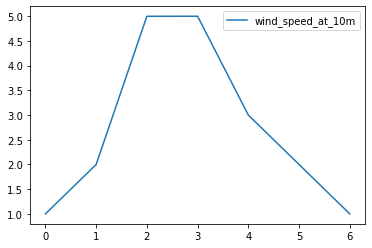

In [202]:
wind_speed.plot()
plt.show()

#### For all pollutants

Cycling through all the pollutant species:

In [193]:
# Specify pollutant variables to be gridded
variables = [var for var in list(new_ds.data_vars) if "wind" not in var]
variables

['NOx', 'NO2', 'PM10', 'PM2.5', 'CO2']

We need to exclude the wind variables because the data points are for the whole region and don't have a spatial distribution.

In [194]:
for variable in variables:
    print(variable)

    # Grid the timeseries data
    cell_list = []
    progress_bar = tqdm(range(0, new_ds.PG_class.shape[0]))

    for i in progress_bar:
        progress_bar.set_description(f"Gridding PG classes")
        cell = ref_cell.copy()
        class_gdf = gpd.GeoDataFrame(new_ds[variable][i, :].values, 
                         columns=[f"class_{variable}"], 
                         geometry=gpd.points_from_xy(new_ds.longitude.values, new_ds.latitude.values))
        merge = gpd.sjoin(class_gdf, ref_cell, how="left", predicate="within")
        dissolve = merge.dissolve(by="index_right", aggfunc="mean")
        cell.loc[dissolve.index, f"class_{variable}"] = dissolve[f"class_{variable}"].values
        cell_list.append(cell[f"class_{variable}"].values.reshape(len(x_coords),len(y_coords)))

    # Stack the grids into a numpy array
    classes_gridded = np.stack(cell_list, axis=-1)

    # Create the xarray dataset
    data_variables = {f"{variable}": (["longitude", "latitude", "time"], classes_gridded, new_ds[variable].attrs)
                        }

    coords = {"longitude": (["longitude"], x_coords),
                "latitude": (["latitude"], y_coords),
             "PG_class": (["PG_class"], new_ds.PG_class.data)}

    attrs = new_ds.attrs

    classes_ds = xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

    # Save to a netCDF file
    if not path.exists(path.join(folder, "gridded")):
        makedirs(path.join(folder, "gridded"))
    filepath = path.join(folder, "gridded", f"{variable}_PG_classes_grid.nc")
    classes_ds.to_netcdf(filepath)
    print(f"Saved to {filepath}.")

Gridding PG classes:   0%|          | 0/7 [00:00<?, ?it/s]

NOx


Gridding PG classes:   0%|          | 0/7 [00:00<?, ?it/s]

Saved to /home/users/mwlw3/ADMS-Urban/2018_P-G_classes/region01/006/gridded/NOx_PG_classes_grid.nc.
NO2


Gridding PG classes:   0%|          | 0/7 [00:00<?, ?it/s]

Saved to /home/users/mwlw3/ADMS-Urban/2018_P-G_classes/region01/006/gridded/NO2_PG_classes_grid.nc.
PM10


Gridding PG classes:   0%|          | 0/7 [00:00<?, ?it/s]

Saved to /home/users/mwlw3/ADMS-Urban/2018_P-G_classes/region01/006/gridded/PM10_PG_classes_grid.nc.
PM2.5


Gridding PG classes:   0%|          | 0/7 [00:00<?, ?it/s]

Saved to /home/users/mwlw3/ADMS-Urban/2018_P-G_classes/region01/006/gridded/PM2.5_PG_classes_grid.nc.
CO2


Gridding PG classes: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]

Saved to /home/users/mwlw3/ADMS-Urban/2018_P-G_classes/region01/006/gridded/CO2_PG_classes_grid.nc.


#### Visualise the timeseries as an animation

In [36]:
variable = "NO2"

In [71]:
classes_ds = xr.open_dataset(path.join(folder, "gridded", f"{variable}_timeseries_grid.nc")).transpose("time", "latitude", "longitude")

In [123]:
daily_da = timeseries_ds[variable].groupby("time.dayofyear").mean("time")
daily_da.shape

(365, 18, 28)

In [124]:
frames = []

for i in tqdm(range(0, daily_da.dayofyear.size)):
    image = daily_da[dict(dayofyear=i)].plot(figsize=(10,5), 
                                                       cmap="plasma_r", 
                                                       vmin=0, 
                                                       vmax=daily_da.max())
    images_folder = path.join(path.abspath(""), "tmp", "gif_images")
    image_filepath = path.join(images_folder, f"{variable}_T{i}.png")
    plt.savefig(image_filepath)
    plt.close()

    new_frame = Image.open(image_filepath)
    frames.append(new_frame)
    remove(image_filepath)

frames[0].save(path.join(folder, f"{variable}_daily_mean_timeseries.gif"), format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)

100%|██████████| 365/365 [01:22<00:00,  4.42it/s]


KeyError: 'MP4'